<a href="https://colab.research.google.com/github/ThatAvgGuy/MLPC/blob/main/Smart_Gridynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pygad


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pygad
import time


In [15]:
# Update path to match your file location
csv_path = "/content/synthetic_smartgrid_data.csv"
df_raw = pd.read_csv(csv_path)

num_nodes = 10
num_sources = 3
num_hours = 24

# Demand matrix: shape (nodes x hours)
demand_np = df_raw[[f"N{i+1}_Demand" for i in range(num_nodes)]].T.to_numpy()

# Simulated dynamic cost: shape (sources x nodes x hours)
cost_np = np.zeros((num_sources, num_nodes, num_hours))
base_costs = [0.2, 0.4, 0.3]  # Solar, Wind, Hydro

for s in range(num_sources):
    fluctuation = np.random.uniform(-0.05, 0.05, (num_nodes, num_hours))
    cost_np[s] = base_costs[s] + fluctuation

# Capacity: sources x hours
capacity_np = df_raw[["S1_Solar", "S2_Wind", "S3_Hydro"]].T.to_numpy()

# Transmission loss between each source-node pair
loss_np = np.random.uniform(0.05, 0.15, (num_sources, num_nodes))


In [4]:
POP_SIZE = 50
NUM_GENERATIONS = 40
CHROMOSOME_LENGTH = num_sources * num_nodes * num_hours
MUTATION_PCT = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def fitness_cpu(chrom):
    energy = chrom.reshape(num_sources, num_nodes, num_hours)
    cost = np.sum(energy * cost_np)
    loss = np.sum(energy * loss_np[:, :, None])
    supplied = np.sum(energy * (1 - loss_np[:, :, None]), axis=0)
    demand_gap = demand_np - supplied
    demand_penalty = np.sum(np.square(np.clip(demand_gap, 0, None)))
    usage = np.sum(energy, axis=1)
    over_capacity = np.clip(usage - capacity_np, 0, None)
    capacity_penalty = np.sum(over_capacity)
    return cost + loss + demand_penalty + 10 * capacity_penalty


In [6]:
def fitness_torch(chrom_tensor):
    energy = chrom_tensor.view(num_sources, num_nodes, num_hours)
    cost_tensor = torch.tensor(cost_np, dtype=torch.float32, device=device)
    loss_tensor = torch.tensor(loss_np, dtype=torch.float32, device=device)
    demand_tensor = torch.tensor(demand_np, dtype=torch.float32, device=device)
    capacity_tensor = torch.tensor(capacity_np, dtype=torch.float32, device=device)

    cost = torch.sum(energy * cost_tensor)
    loss = torch.sum(energy * loss_tensor[:, :, None])
    supplied = torch.sum(energy * (1 - loss_tensor[:, :, None]), dim=0)
    demand_gap = demand_tensor - supplied
    demand_penalty = torch.sum(torch.square(torch.clamp(demand_gap, min=0)))
    usage = torch.sum(energy, dim=1)
    over_capacity = torch.clamp(usage - capacity_tensor, min=0)
    capacity_penalty = torch.sum(over_capacity)
    return cost + loss + demand_penalty + 10 * capacity_penalty


In [7]:
def pygad_fitness(ga_instance, solution, solution_idx):
    return -fitness_cpu(solution)

start_cpu = time.time()
ga_instance = pygad.GA(
    num_generations=NUM_GENERATIONS,
    num_parents_mating=10,
    fitness_func=pygad_fitness,
    sol_per_pop=POP_SIZE,
    num_genes=CHROMOSOME_LENGTH,
    gene_space={'low': 1.0, 'high': 8.0},
    mutation_percent_genes=MUTATION_PCT,
    parent_selection_type="rws",
    crossover_type="single_point",
    mutation_type="random",
    stop_criteria=["reach_0.01"]
)
ga_instance.run()
end_cpu = time.time()
cpu_time = end_cpu - start_cpu
fitness_curve_cpu = [-f for f in ga_instance.best_solutions_fitness]


In [8]:
def run_pytorch_ga():
    population = [torch.rand(CHROMOSOME_LENGTH, device=device) * 10 for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(NUM_GENERATIONS):
        fitness_scores = [fitness_torch(ind) for ind in population]
        best_fitness = min(f.item() for f in fitness_scores)
        fitness_curve.append(best_fitness)

        new_population = []
        for _ in range(POP_SIZE // 2):
            idx = np.random.choice(len(population), 2, replace=False)
            p1, p2 = population[idx[0]], population[idx[1]]
            point = np.random.randint(1, CHROMOSOME_LENGTH - 1)
            c1 = torch.cat([p1[:point], p2[point:]])
            c2 = torch.cat([p2[:point], p1[point:]])
            for c in [c1, c2]:
                mutation_mask = torch.rand(CHROMOSOME_LENGTH, device=device) < 0.08
                c[mutation_mask] = torch.rand(torch.sum(mutation_mask), device=device) * 10
                new_population.append(c)

        population = new_population

    return fitness_curve

start_gpu = time.time()
fitness_curve_gpu = run_pytorch_ga()
torch.cuda.synchronize()
end_gpu = time.time()
gpu_time = end_gpu - start_gpu


In [9]:
def run_greedy():
    total_cost = 0
    total_loss = 0
    demand_penalty = 0
    cap_copy = capacity_np.copy()

    for h in range(num_hours):
        for n in range(num_nodes):
            remaining_demand = demand_np[n, h]
            effective_costs = [(s, cost_np[s, n, h] / (1 - loss_np[s, n])) for s in range(num_sources)]
            effective_costs.sort(key=lambda x: x[1])

            for s, _ in effective_costs:
                if remaining_demand <= 0:
                    break
                available = cap_copy[s, h]
                deliverable = available * (1 - loss_np[s, n])
                to_assign = min(remaining_demand, deliverable)
                if to_assign > 0:
                    required_energy = to_assign / (1 - loss_np[s, n])
                    total_cost += required_energy * cost_np[s, n, h]
                    total_loss += required_energy * loss_np[s, n]
                    cap_copy[s, h] -= required_energy
                    remaining_demand -= to_assign

            if remaining_demand > 0:
                demand_penalty += remaining_demand ** 2

    return total_cost + total_loss + demand_penalty, total_cost, total_loss, demand_penalty

start_greedy = time.time()
greedy_fit, greedy_cost, greedy_loss, greedy_demand_penalty = run_greedy()
end_greedy = time.time()
greedy_time = end_greedy - start_greedy


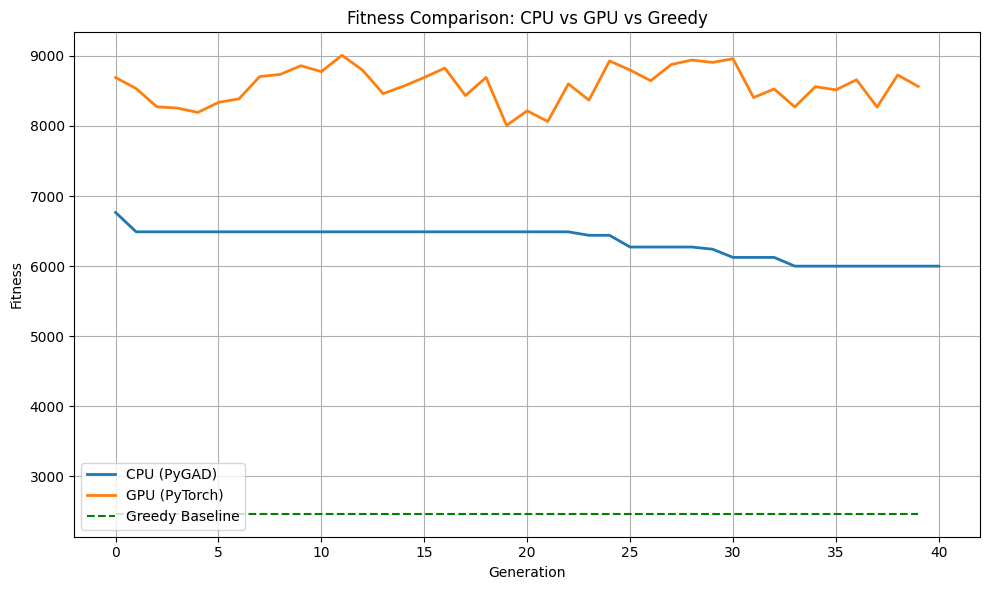

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(fitness_curve_cpu, label="CPU (PyGAD)", linewidth=2)
plt.plot(fitness_curve_gpu, label="GPU (PyTorch)", linewidth=2)
plt.hlines(y=greedy_fit, xmin=0, xmax=NUM_GENERATIONS-1, colors='green', linestyles='dashed', label="Greedy Baseline")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Comparison: CPU vs GPU vs Greedy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


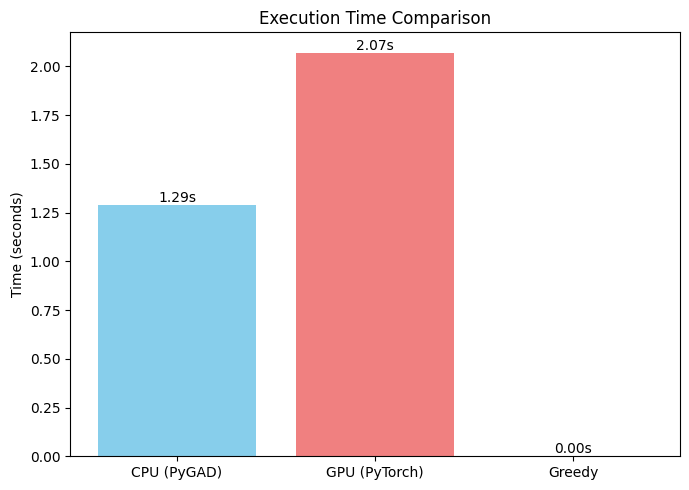

In [11]:
plt.figure(figsize=(7, 5))
times = [cpu_time, gpu_time, greedy_time]
labels = ['CPU (PyGAD)', 'GPU (PyTorch)', 'Greedy']
colors = ['skyblue', 'lightcoral', 'limegreen']
bars = plt.bar(labels, times, color=colors)
plt.ylabel("Time (seconds)")
plt.title("Execution Time Comparison")
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f"{time_val:.2f}s", ha='center', va='bottom')
plt.tight_layout()
plt.show()


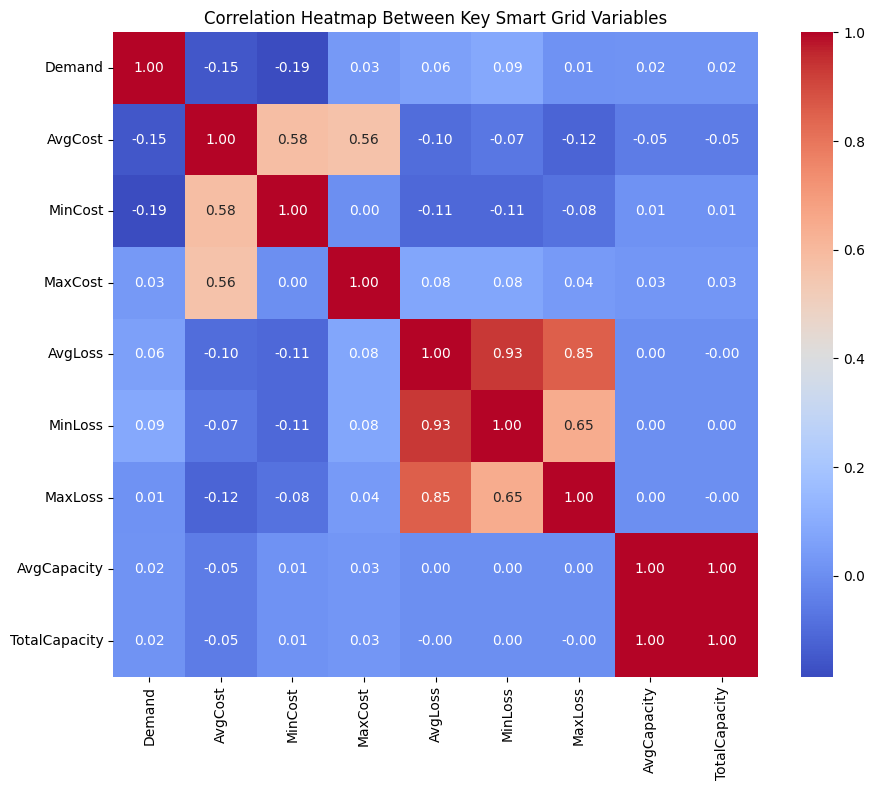

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming the following already exist:
# - demand_np (shape: num_nodes x num_hours)
# - cost_np (shape: num_sources x num_nodes x num_hours)
# - loss_np (shape: num_sources x num_nodes)
# - capacity_np (shape: num_sources x num_hours)

# Parameters
num_nodes = demand_np.shape[0]
num_hours = demand_np.shape[1]

# -----------------------
# Build node-hour records
# -----------------------
records = []

for n in range(num_nodes):
    for h in range(num_hours):
        record = {
            "Node": n + 1,
            "Hour": h,
            "Demand": demand_np[n, h],
            "AvgCost": np.mean(cost_np[:, n, h]),
            "MinCost": np.min(cost_np[:, n, h]),
            "MaxCost": np.max(cost_np[:, n, h]),
            "AvgLoss": np.mean(loss_np[:, n]),
            "MinLoss": np.min(loss_np[:, n]),
            "MaxLoss": np.max(loss_np[:, n]),
            "AvgCapacity": np.mean(capacity_np[:, h]),
            "TotalCapacity": np.sum(capacity_np[:, h])
        }
        records.append(record)

# Convert to DataFrame
df_corr = pd.DataFrame(records)

# -----------------------
# Correlation Heatmap
# -----------------------
corr_matrix = df_corr.drop(columns=["Node", "Hour"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap Between Key Smart Grid Variables")
plt.tight_layout()
plt.show()
